In [1]:
import numpy as np
import time
from imageio import imread
import matplotlib.pyplot as plt

from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage.filters import convolve
from skimage.draw import circle
from skimage.transform import resize
from functools import partial

(256, 256)


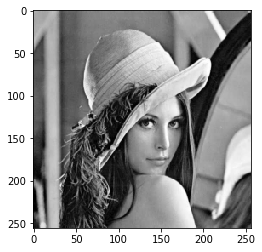

In [7]:
im = imread("../../samples/lena.jpg", pilmode="L")
im = resize(im, (256, 256), order=1, anti_aliasing=True, mode="reflect") 
im = (im*255).astype(np.uint8)
plt.imshow(im, cmap="gray")
print(im.shape)
plt.show()

# Exercise 4: Filtering in Frequency Domain

The Fourier transformation in the descrete domain is defined as:

$$
\begin{align}
F(u,v)
    &= \sum_{x=0}^{M}\sum_{y=0}^{N}f(x,y) \cdot e^{-2i\pi\cdot\left(\dfrac{u \cdot x}{M} + \dfrac{v \cdot y}{N} \right)} \\
    &= \sum_{x=0}^{M}\sum_{y=0}^{N} \dfrac{f(x,y)}{e^{2i\pi\cdot\left(\dfrac{u \cdot x}{M} + \dfrac{v \cdot y}{N} \right)}} \\
e^{i \cdot \rho \cdot x} 
    &= \mathrm{cos}(\rho \cdot x) + i\cdot \mathrm{sin}(\rho \cdot x)
\end{align}
$$




## Task 3 - Low- / High-Pass filters

1. Implement a functions, that performs ideal pass filtering (low- and high-pass). Visualize the filter masks of the ideal low- and high-pass filters!
2. Implement a functions, that performs gaussian pass filtering (low- and high-pass). Visualize the filter masks of the gaussian low- and high-pass filters!
3. Compare both functions qualitatively!

In [8]:
def normalize(im):
    """
        Small helper function for image renormalization
    """
    im = im.astype(np.float32)
    im -= im.min()
    im /= im.max()
    return im
    

def DFT(im, shift=False):
    if im.dtype == np.uint8:
        im = im.astype(np.float) / 255
    
    I = fft2(im)
    if shift:
        I = fftshift(I)
    
    return I

def iDFT(I, shift=False, norm=False):
    if shift:
        I = ifftshift(I)
    
    im = ifft2(I)
    if norm:
        im = normalize(im.real)
    else:
        im = im.real
    im = np.round(im * 255)
    
    return im.astype(np.uint8)

In [9]:

def gauss_filter(size, sigma=1):
    """
        creates gaussian kernel with a given size and sigma
    """
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))

    return kernel / kernel.sum()

def pass_filter(im, radius_ratio=0.2, ideal=True, is_high_pass=True):
    I = DFT(im, shift=True)
    radius = int(min(im.shape) * radius_ratio)

    if ideal:
        pass_mask = np.zeros_like(I)
        mid_x, mid_y = im.shape[1] // 2, im.shape[0] // 2

        rr, cc = circle(mid_x, mid_y, radius)
        pass_mask[rr, cc] = 1
    else:
        pass_mask = gauss_filter(min(im.shape), radius)
        pass_mask /= pass_mask.max()
        
    if is_high_pass:
        pass_mask = 1 - pass_mask
    
    res = iDFT(I * pass_mask, shift=True, norm=True)
    #res = (normalize(res) * 255).astype(np.uint8)
    return res, pass_mask.real

high_pass = partial(pass_filter, is_high_pass=True)
low_pass = partial(pass_filter, is_high_pass=False)

/home/korsch/.anaconda3/envs/chainer4/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


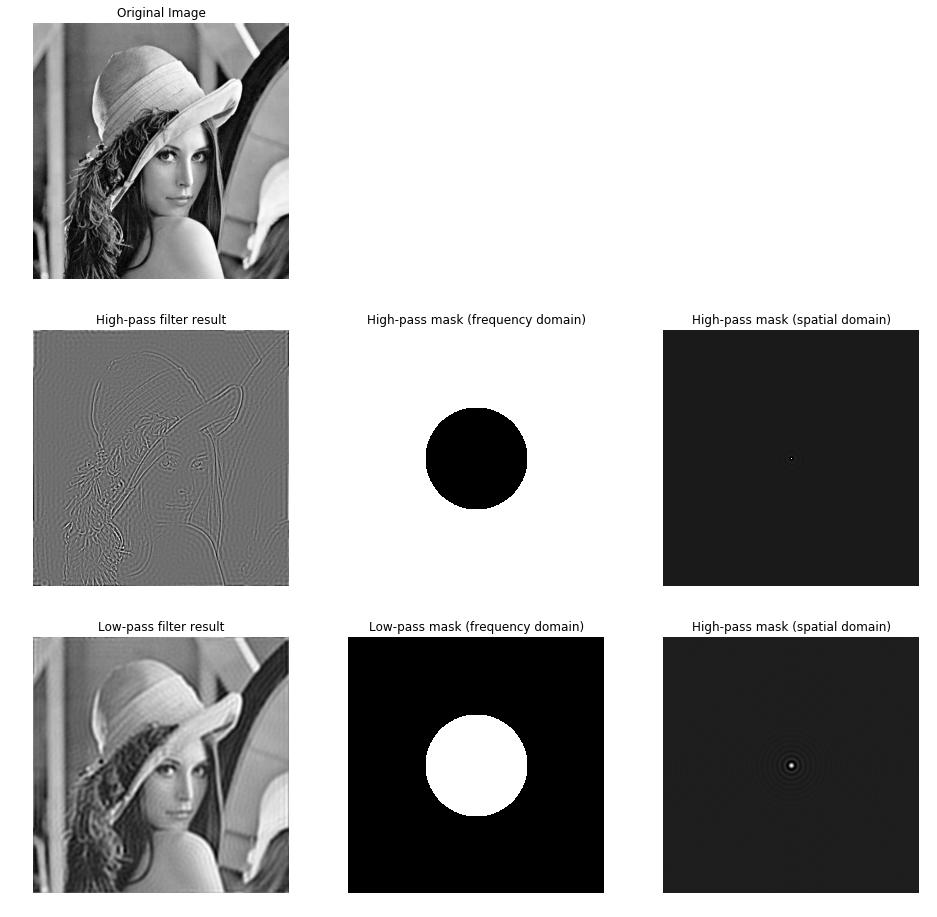

In [10]:
_im = im.copy()

R = 0.2
im0, mask0 = high_pass(_im, R)
im1, mask1 = low_pass(_im, R)

sp_mask0 = fftshift(ifft2(fftshift(mask0))).real
sp_mask1 = fftshift(ifft2(fftshift(mask1))).real

fig, axs = plt.subplots(3,3, figsize=(16, 16))
[ax.axis("off") for ax in axs.ravel()]

axs[0,0].imshow(_im, cmap=plt.cm.gray)
axs[0,0].set_title("Original Image")

axs[1,0].imshow(im0, cmap=plt.cm.gray)
axs[1,0].set_title("High-pass filter result")

axs[1,1].imshow(mask0, cmap=plt.cm.gray)
axs[1,1].set_title("High-pass mask (frequency domain)")

axs[1,2].imshow(sp_mask0, cmap=plt.cm.gray)
axs[1,2].set_title("High-pass mask (spatial domain)")

axs[2,0].imshow(im1, cmap=plt.cm.gray)
axs[2,0].set_title("Low-pass filter result")

axs[2,1].imshow(mask1, cmap=plt.cm.gray)
axs[2,1].set_title("Low-pass mask (frequency domain)")

axs[2,2].imshow(sp_mask1, cmap=plt.cm.gray)
axs[2,2].set_title("High-pass mask (spatial domain)")

plt.show()
plt.close()

/home/korsch/.anaconda3/envs/chainer4/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


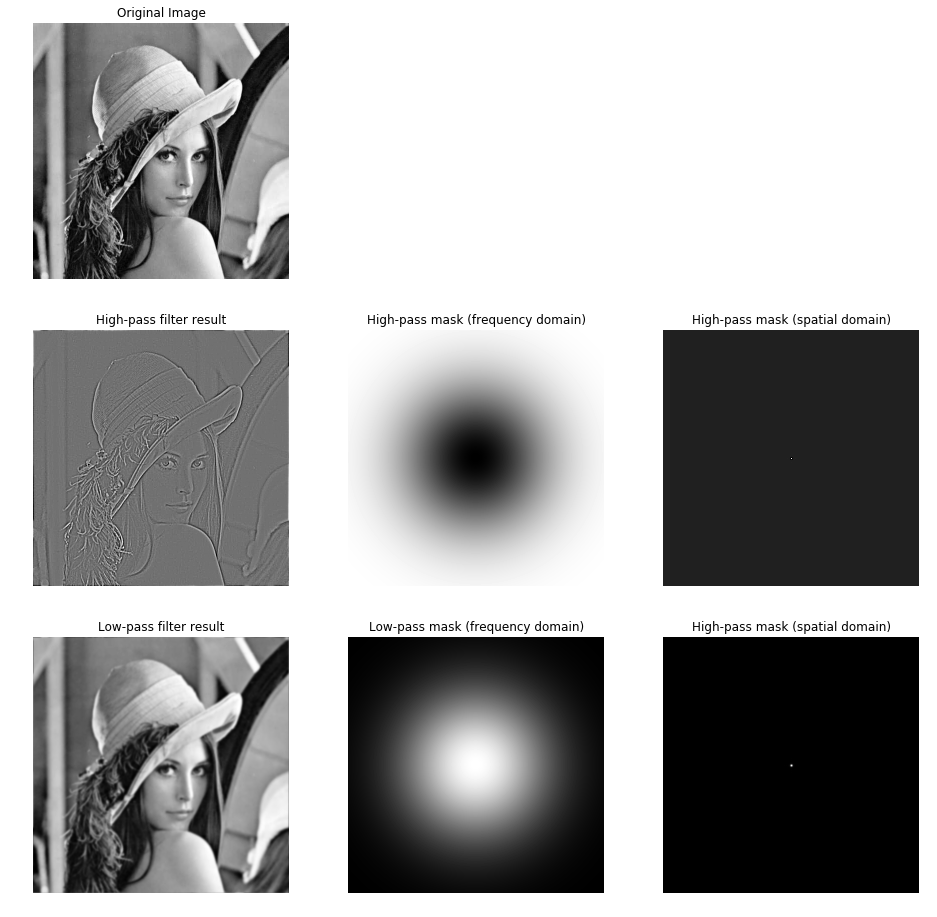

In [11]:
_im = im.copy()

R = 0.2
im0, mask0 = high_pass(_im, R, ideal=False)
im1, mask1 = low_pass(_im, R, ideal=False)

sp_mask0 = fftshift(ifft2(fftshift(mask0))).real
sp_mask1 = fftshift(ifft2(fftshift(mask1))).real

fig, axs = plt.subplots(3,3, figsize=(16, 16))
[ax.axis("off") for ax in axs.ravel()]

axs[0,0].imshow(_im, cmap=plt.cm.gray)
axs[0,0].set_title("Original Image")

axs[1,0].imshow(im0, cmap=plt.cm.gray)
axs[1,0].set_title("High-pass filter result")

axs[1,1].imshow(mask0, cmap=plt.cm.gray)
axs[1,1].set_title("High-pass mask (frequency domain)")

axs[1,2].imshow(sp_mask0, cmap=plt.cm.gray)
axs[1,2].set_title("High-pass mask (spatial domain)")

axs[2,0].imshow(im1, cmap=plt.cm.gray)
axs[2,0].set_title("Low-pass filter result")

axs[2,1].imshow(mask1, cmap=plt.cm.gray)
axs[2,1].set_title("Low-pass mask (frequency domain)")

axs[2,2].imshow(sp_mask1, cmap=plt.cm.gray)
axs[2,2].set_title("High-pass mask (spatial domain)")

plt.show()
plt.close()